In [14]:
import altair as alt
import polars as pl

alt.data_transformers.enable("vegafusion")
alt.renderers.enable("png")

RendererRegistry.enable('png')

## Ingest

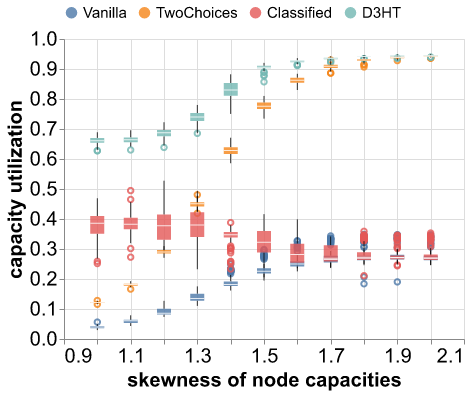

In [130]:
df = pl.read_csv(
    "ingest/*-sys.csv", schema_overrides={"capacity_skew": pl.Float32}
).with_columns(
    (pl.col("utilized_capacity") / pl.col("total_capacity")).alias(
        "capacity utilization"
    ),
    (pl.col("total_capacity") / pl.col("num_node")).alias("average node capacity"),
    (pl.col("strategy").replace("Classified+TwoChoices", "D3HT").alias("strategy2")),
)
util = (
    alt.Chart(df)
    .mark_boxplot(opacity=0.8)
    .encode(
        alt.X("capacity_skew").scale(zero=False).axis(title="skewness of node capacities"),
        alt.Y("capacity utilization"),
        alt.Color("strategy2")
        .sort(["Vanilla", "Classified", "TwoChoices"])
        .legend(
            orient="top",
            labelFontSize=15,
            title=None,
        ),
    )
    .properties(width=400, height=300)
    .configure_axis(labelFontSize=20, titleFontSize=20)
)
util

In [131]:
util.save("graphs/util.pdf")

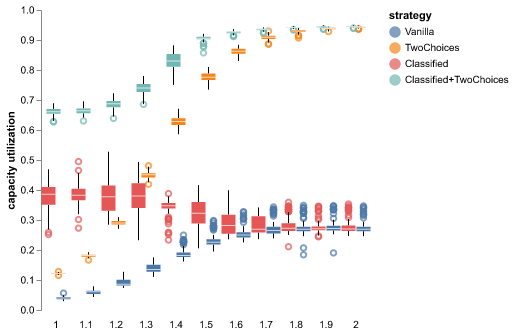

In [5]:
(
    alt.Chart(df)
    .mark_boxplot()
    .encode(
        alt.X("strategy").axis(None),
        alt.Y("capacity utilization"),
        alt.Color("strategy").sort(
            ["Vanilla", "Classified", "TwoChoices", "Classified+TwoChoices"]
        ),
        alt.Column("capacity_skew").header(title=None, labelOrient="bottom").spacing(0),
    )
    .configure_axis(grid=False)
    .configure_view(stroke=None)
    .properties(width=20)
)

In [6]:
df = pl.read_csv(
    "ingest/*-bin.csv", schema_overrides={"capacity_skew": pl.Float32}
).with_columns(
    (pl.col("bin_capacity") / pl.col("num_bin_node")).alias("bin average capacity"),
    (pl.col("bin_used_capacity") / pl.col("bin_capacity")).alias("bin utilization"),
    (pl.col("bin_hit_count") / pl.col("num_bin_node")).alias("bin average hit"),
    (pl.col("bin_hit_count") / pl.col("bin_capacity")).alias("bin capacity frequency"),
)
df

num_node,node_min_capacity,node_max_capacity,capacity_skew,num_copy,strategy,bin_index,num_bin_node,bin_hit_count,bin_capacity,bin_used_capacity,bin_max_utilization,bin average capacity,bin utilization,bin average hit,bin capacity frequency
i64,i64,i64,f32,i64,str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64
12000,1024,102400,1.0,3,"""Vanilla""",0,7395,2942244,8577888,2938623,1.0,1159.957809,0.342581,397.869371,0.343003
12000,1024,102400,1.0,3,"""Vanilla""",1,1064,421633,3070267,421633,0.601559,2885.589286,0.137328,396.271617,0.137328
12000,1024,102400,1.0,3,"""Vanilla""",2,858,338361,4997549,338361,0.2180279,5824.649184,0.067705,394.36014,0.067705
12000,1024,102400,1.0,3,"""Vanilla""",3,758,300759,8990150,300759,0.103598,11860.356201,0.033454,396.779683,0.033454
12000,1024,102400,1.0,3,"""Vanilla""",4,690,272461,16360869,272461,0.070975,23711.404348,0.016653,394.871014,0.016653
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12000,1024,102400,2.0,3,"""Classified+TwoChoices""",0,11993,11729909,12321368,11684664,1.0,1027.379972,0.948325,978.062953,0.951997
12000,1024,102400,2.0,3,"""Classified+TwoChoices""",1,7,18724,18845,18640,1.0,2692.142857,0.989122,2674.857143,0.993579
12000,1024,102400,2.0,3,"""Classified+TwoChoices""",0,11991,11702689,12324127,11669031,1.0,1027.781419,0.946844,975.95605,0.949575


## Frequency

### Storage frequency balance across classes

In [123]:
df = (
    pl.read_csv("freq/*-class.csv")
    .with_columns(
        (
            pl.col("class_hit_count") / pl.col("num_find") / pl.col("num_class_node")
        ).alias("class node frequency"),
        (pl.col("class") + 10).alias("class2")
    )
    .with_columns(
        (pl.col("class node frequency") / pl.col("class_capacity")).alias(
            "class storage frequency"
        ),
    )
)
df

strategy,num_node,num_find,find_size,num_class,skew,class,num_class_node,class_capacity,class_hit_count,class node frequency,class2,class storage frequency
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64
"""Vanilla""",10000,1000000,3,8,1,0,163804,163804,49181137,0.0003,10,1.8329e-9
"""Vanilla""",10000,1000000,3,8,1,1,135424,325018,40557524,0.000299,11,9.2144e-10
"""Vanilla""",10000,1000000,3,8,1,2,124762,657266,37490232,0.0003,12,4.5719e-10
"""Vanilla""",10000,1000000,3,8,1,3,118135,1302985,35409148,0.0003,13,2.3004e-10
"""Vanilla""",10000,1000000,3,8,1,4,116188,2622068,34845516,0.0003,14,1.1438e-10
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Classified""",10000,1000000,3,8,1,3,118465,1306774,9731118,0.000082,13,6.2860e-11
"""Classified""",10000,1000000,3,8,1,4,115407,2604535,18924662,0.000164,14,6.2960e-11
"""Classified""",10000,1000000,3,8,1,5,114265,5222635,37451145,0.000328,15,6.2757e-11


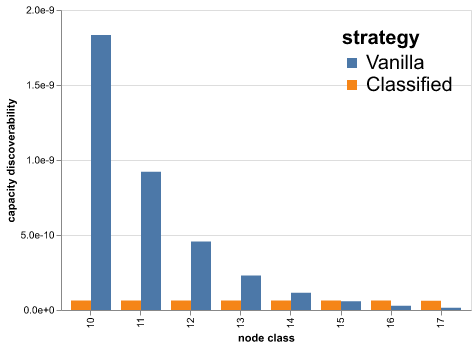

In [125]:
class_freq = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        alt.X("class2:N").axis(title="node class"),
        alt.Y("class storage frequency").axis(format=".1e", tickCount=5, title="capacity discoverability"),
        alt.Color("strategy").sort(["Vanilla", "Classified"]).legend(orient="top-right", labelFontSize=20, titleFontSize=20),
        alt.XOffset("strategy"),
    )
)
class_freq

In [10]:
class_freq.save("graphs/class-capacity-freq.pdf")

### Node frequency CDF

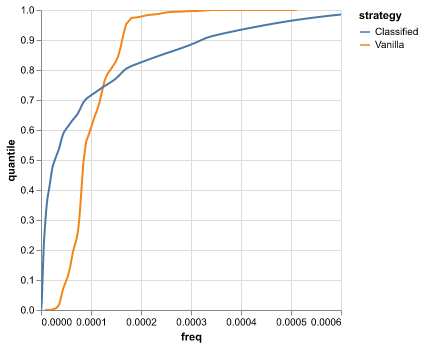

In [11]:
df = pl.read_csv("freq/*-node.csv")
df
chart = (
    alt.Chart(df)
    .mark_line(clip=True)
    .encode(
        alt.X("freq").scale(domainMax=0.0006), alt.Y("quantile"), alt.Color("strategy")
    )
)
chart

### Capacity frequency CDF

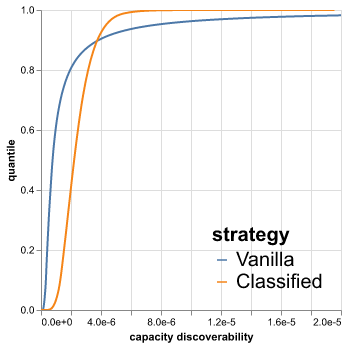

In [126]:
df = pl.read_csv("freq/*-capacity.csv")
df
cdf = (
    alt.Chart(df)
    .mark_line(clip=True)
    .encode(
        alt.X("freq").scale(domainMax=0.00002).axis(format=".1e", title="capacity discoverability"),
        alt.Y("quantile").axis(tickCount=5),
        alt.Color("strategy").sort(["Vanilla", "Classified"]).legend(orient="bottom-right", labelFontSize=20, titleFontSize=20),
    )
)
cdf

In [ ]:
cdf.save("graphs/capacity-freq-cdf.pdf")

In [190]:
(cdf | class_freq).configure_axis(labelFontSize=20, titleFontSize=20)
(cdf | class_freq).configure_axis(labelFontSize=20, titleFontSize=20).save(
    "graphs/capacity-freq.pdf"
)

## Inject with rejection

### Number of attempts vs. utilized capacity

In [112]:
df = pl.read_csv("ingest-reject/*.csv").with_columns(
    (pl.col("num_stored") * pl.col("num_copy") / pl.col("supply")).alias("utilization"),
    (1 - pl.col("store_rate")).alias("rejection rate"),
    (pl.col("strategy").replace("Classified+TwoChoices", "D3HT").alias("strategy2")),
)
df

num_node,node_min_capacity,capacity_multiplier,capacity_skew,num_copy,strategy,supply,num_attempt,store_rate,num_stored,utilization,rejection rate,strategy2
i64,i64,i64,i64,i64,str,i64,i64,f64,i64,f64,f64,str
12000,1024,128,1,3,"""Vanilla""",136508433,100000,1.0,100000,0.002198,0.0,"""Vanilla"""
12000,1024,128,1,3,"""Vanilla""",136508433,200000,1.0,200000,0.004395,0.0,"""Vanilla"""
12000,1024,128,1,3,"""Vanilla""",136508433,300000,1.0,300000,0.006593,0.0,"""Vanilla"""
12000,1024,128,1,3,"""Vanilla""",136508433,400000,1.0,400000,0.008791,0.0,"""Vanilla"""
12000,1024,128,1,3,"""Vanilla""",136508433,500000,1.0,500000,0.010988,0.0,"""Vanilla"""
…,…,…,…,…,…,…,…,…,…,…,…,…
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9600000,1.0,9600000,0.204703,0.0,"""D3HT"""
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9700000,1.0,9700000,0.206835,0.0,"""D3HT"""
12000,1024,128,1,3,"""Classified+TwoChoices""",140691860,9800000,1.0,9800000,0.208967,0.0,"""D3HT"""


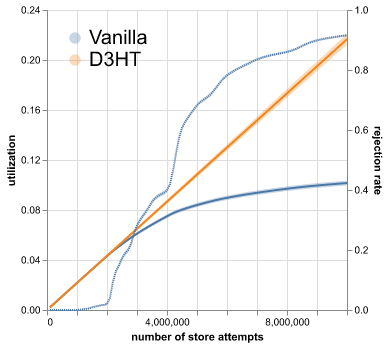

In [113]:
base = alt.Chart(df).encode(
    alt.X("num_attempt"),
    alt.Color("strategy2")
    .sort(["Vanilla"])
    .legend(title=None, orient="top-left", labelFontSize=20, titleFontSize=20),
)
num_stored = (
    base.encode(alt.Y("utilization").axis(values=[k*0.04 for k in range(7)])).mark_errorband(extent="stdev")
    + base.encode(alt.Y("utilization", aggregate="mean")).mark_line()
)
base = alt.Chart(df.filter(pl.col("strategy") == "Vanilla")).encode(
    alt.X("num_attempt").axis(title="number of store attempts")
)
rejection_rate = base.encode(
    alt.Y("rejection rate", aggregate="mean").scale(domain=(0., 1.)).axis(tickCount=5)
).mark_line(strokeDash=[1, 1]) + base.encode(alt.Y("rejection rate")).mark_errorband(
    extent="stdev"
)
reject = (
    alt.layer(num_stored, rejection_rate)
    .resolve_axis(y="independent")
    .resolve_scale(y="independent")
)
reject

In [114]:
df = (
    pl.read_csv("ingest-evict/*.csv")
    .with_columns(
        (pl.col("num_stored") * pl.col("num_copy") / pl.col("supply")).alias(
            "utilization"
        ),
        (pl.col("num_loss") / pl.col("num_stored")).alias("loss rate"),
        (pl.col("num_evict") / pl.col("supply")).alias("evicted utilization"),
    )
    .with_columns(
        pl.col("utilization").round(2).alias("binned utilization"),
        (pl.col("utilization") - pl.col("evicted utilization")).alias(
            "actual utilization"
        ),
    )
)
df

num_node,node_min_capacity,capacity_multiplier,capacity_skew,num_copy,strategy,supply,num_stored,num_evict,num_loss,utilization,loss rate,evicted utilization,binned utilization,actual utilization
i64,i64,i64,i64,i64,str,i64,i64,i64,i64,f64,f64,f64,f64,f64
12000,1024,128,1,3,"""Vanilla""",139308976,100000,0,0,0.002153,0.0,0.0,0.0,0.002153
12000,1024,128,1,3,"""Vanilla""",139308976,200000,0,0,0.004307,0.0,0.0,0.0,0.004307
12000,1024,128,1,3,"""Vanilla""",139308976,300000,0,0,0.00646,0.0,0.0,0.01,0.00646
12000,1024,128,1,3,"""Vanilla""",139308976,400000,0,0,0.008614,0.0,0.0,0.01,0.008614
12000,1024,128,1,3,"""Vanilla""",139308976,500000,0,0,0.010767,0.0,0.0,0.01,0.010767
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12000,1024,128,1,3,"""Vanilla""",134880212,9600000,9588313,614926,0.213523,0.064055,0.071088,0.21,0.142435
12000,1024,128,1,3,"""Vanilla""",134880212,9700000,9779221,634392,0.215747,0.065401,0.072503,0.22,0.143244
12000,1024,128,1,3,"""Vanilla""",134880212,9800000,9970672,653963,0.217971,0.066731,0.073922,0.22,0.144049


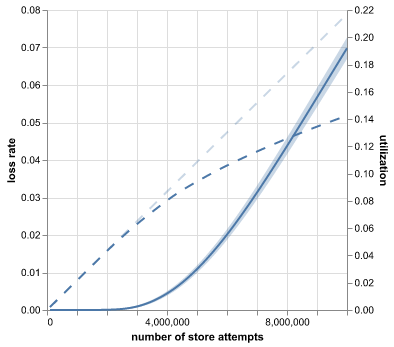

In [115]:
base = alt.Chart(df).encode(alt.X("num_stored"))
loss = (
    base.encode(alt.Y("loss rate").scale(domainMin=0.0)).mark_errorband(extent="stdev")
    + base.encode(alt.Y("loss rate", aggregate="mean")).mark_line()
)
base = alt.Chart(df).encode(alt.X("num_stored").axis(title="number of store attempts"))
util = base.encode(alt.Y("utilization", aggregate="mean").axis(title="utilization")).mark_line(
    strokeDash=[10, 10], opacity=0.3
)
actual_util = base.encode(alt.Y("actual utilization", aggregate="mean")).mark_line(
    strokeDash=[10, 10],
)
evict = (
    alt.layer(loss, (util + actual_util))
    .resolve_axis(y="independent")
    .resolve_scale(y="independent")
)
evict

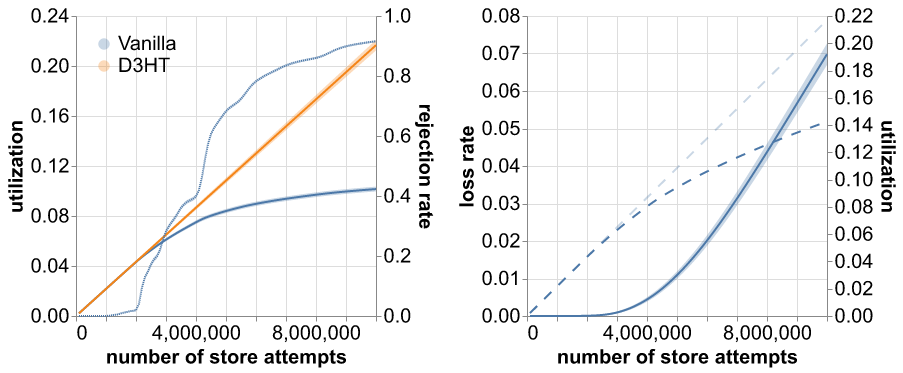

In [118]:
(reject | evict).configure_axis(labelFontSize=20, titleFontSize=20)

In [150]:
(reject | evict).configure_axis(labelFontSize=20, titleFontSize=20).save("graphs/overwhelm.pdf")

## Available capacity heatmap

In [134]:
df = (
    pl.read_csv("ingest-capacity/*-evict.csv")
    .with_columns(
        (
            pl.col("strategy")
            .replace("Classified+TwoChoices", "D3HT")
            .alias("strategy2")
        ),
    )
    .group_by(pl.col("strategy2"), pl.col("capacity"), pl.col("available_capacity"))
    .agg(pl.col("num_bin_node").sum())
)
df

strategy2,capacity,available_capacity,num_bin_node
str,f64,f64,i64
"""Vanilla""",11.18,10.89,9
"""D3HT""",15.08,14.32,6
"""D3HT""",16.54,14.75,1
"""D3HT""",15.89,14.36,4
"""D3HT""",15.43,14.62,7
…,…,…,…
"""D3HT""",15.09,10.61,1
"""D3HT""",16.56,12.0,1
"""D3HT""",10.6,9.76,1


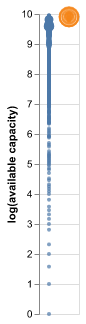

In [183]:
ac_freq = (
    df.filter(pl.col("capacity") == 10)
    .group_by("strategy2", "available_capacity")
    .agg(pl.col("num_bin_node").sum())
)
ac_distr = (
    alt.Chart(ac_freq)
    .encode(
        alt.Y("available_capacity").axis(title="log(available capacity)"),
        alt.Color("strategy2").sort(["Vanilla"]).legend(None),
        alt.X("strategy2").axis(None).sort(["Vanilla"]),
        alt.Size("num_bin_node").legend(None),
    )
    .mark_point()
)
ac_distr

In [189]:
ac_distr.configure_axis(labelFontSize=20, titleFontSize=20).save("graphs/ac-distr.pdf")

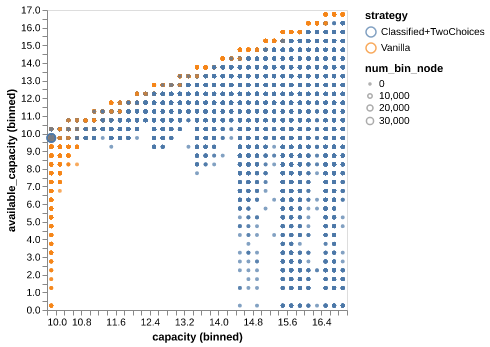

In [ ]:
alt.Chart(df).encode(
    alt.X("capacity").bin(maxbins=40).scale(zero=False),
    alt.Y("available_capacity").bin(maxbins=40).scale(zero=False),
    alt.Color("strategy"),
    alt.Size("num_bin_node"),
).mark_point()

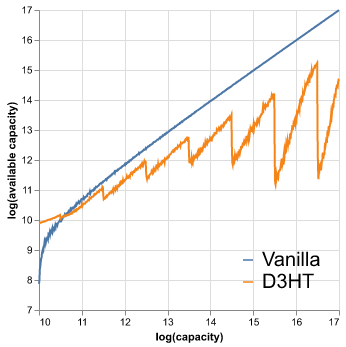

In [184]:
ac_balance = (
    alt.Chart(df)
    .encode(
        alt.X("capacity").scale(zero=False).axis(title="log(capacity)"),
        alt.Y("mean(available_capacity)").scale(zero=False).axis(title="log(available capacity)"),
        alt.Color("strategy2").sort(["Vanilla"]).legend(title=None, orient="bottom-right", labelFontSize=20, titleFontSize=20),
    )
    .mark_line()
)
ac_balance

In [188]:
ac_balance.configure_axis(labelFontSize=20, titleFontSize=20).save("graphs/nc-ac.pdf")

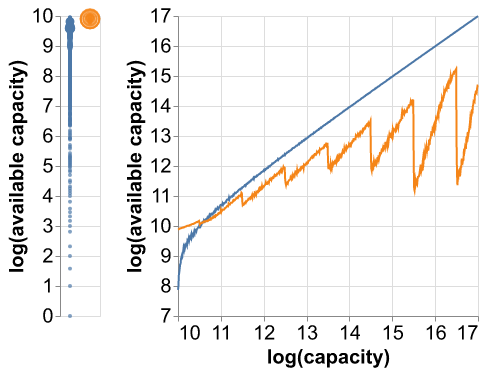

In [185]:
(ac_distr | ac_balance).configure_axis(labelFontSize=20, titleFontSize=20)#.save("graphs/ac-distr.pdf")